In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.fit import ARPSD
from timescales.sim import sim_ar, sim_ar_spectrum

from timescales.plts import set_default_rc
set_default_rc()

# Autoregressive Modeling

Unlike PSD and ACF models, autoregressive (AR) models can operate in the time domain, predict future samples in the time series, generate novel signals, scale in complexity, and have corresponding theoretical PSD and ACF forms.

The `ARPSD` class allows fitting of the spectral AR(p) form. Increasing complexity of the AR models allows us to fit spectra that do not neatly fall in to the AR(1) category as required by a strict defintion of timescales, often the case with empirical data.

This tutorial starts by showing how to a wide range of spectral form low order using the `ARPSD` class. For more complex signals, increasing the AR order allows arbitrarily complex spectra to be fit, e.g. universal approximation. Signals are also simulated or generated based on spectral fits.

In [2]:
# Simulate
n_seconds = 50
fs = 1000
freqs = np.linspace(1e-3, 500, fs)

white_noise =  np.random.randn(int(n_seconds * fs))

sigs = np.vstack((
    sim_ar(n_seconds, fs, np.array([.95])),
    sim_powerlaw(n_seconds, fs, exponent=-2.) * 10,
    sim_powerlaw(n_seconds, fs, exponent=-1),
    white_noise,
    sim_ar(n_seconds, fs, np.array([.2, -.8, .85])),
    sim_ar(n_seconds, fs, np.array([.8, -.1, .2])),
))

freqs, powers = compute_spectrum(sigs, fs, nperseg=3001)

In [3]:
# Fit
order = 5

np.random.seed(0)

ar = ARPSD(
    order,
    fs,
    maxfev=10000,
    bounds=(-1., 1.),
    scaling='log'
)

ar.fit(freqs[1:], powers[:, 1:])

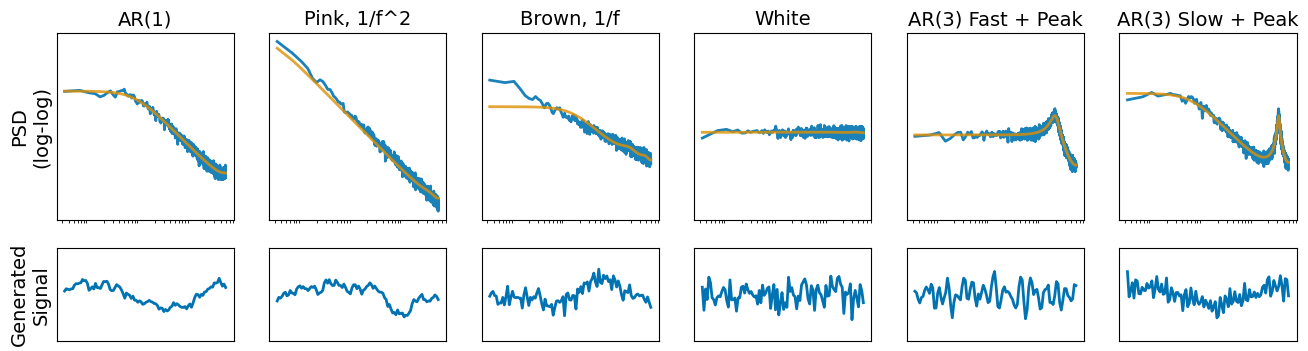

In [4]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=len(powers), height_ratios=[1., .5],
                         figsize=(16, 4), sharex="row", sharey="row")

titles = [
    "AR(1)",
    "Pink, 1/f^2",
    "Brown, 1/f",
    "White",
    "AR(3) Fast + Peak",
    "AR(3) Slow + Peak",
]

for i in range(len(powers)):
    axes[0, i].loglog(freqs[1:], powers[i, 1:], color='C0', alpha=.9, label="Target")
    axes[0, i].loglog(freqs[1:], ar.powers_fit[i], color='C1', alpha=.8, label="Fit")
    axes[0, i].set_title(titles[i], size=14)
    sig_sim = ar.simulate(.1, 1000, index=i)
    sig_sim = (sig_sim - sig_sim.mean()) / sig_sim.std()
    axes[1, i].plot(sig_sim)
    axes[1, i].set_ylim(-5, 5)
    axes[0, i].set_xticks([])
    axes[1, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[1, i].set_yticks([])

axes[0, 0].set_ylabel("PSD\n(log-log)", size=14)
axes[1, 0].set_ylabel("Generated\nSignal", size=14);

## Generative Model

AR(p) model are generative, given an inital input to the linear system, like white noise. The bottom row of the figure above generates a simulated signal, given a spectral fit. For this to work, the roots of the learned AR coefficients must be within in the unit circle, e.g. the model stationary. Check `.is_stationary` attribute to see if the learned spectrum is stationary. If this returns true, the `.simulate` method may be called to generate a signal. Since multiple spectra where fit above, use the `index` kwarg to select which spectrum to simulate based on.

In [5]:
ar.is_stationary

array([ True,  True,  True,  True,  True,  True])

Text(0, 0.5, 'Voltage, a.u.')

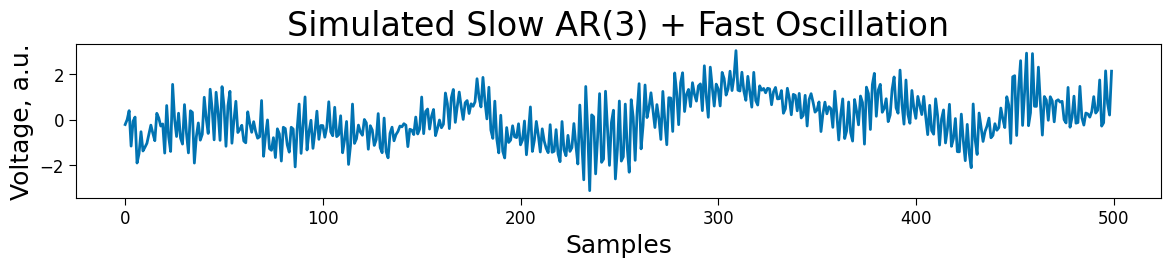

In [6]:
# Simulate a signal
simulated_signal = ar.simulate(1000, 1000, index=-1)

# Plot signal
plt.figure(figsize=(14, 2))
plt.plot(simulated_signal[:500])
plt.title("Simulated Slow AR(3) + Fast Oscillation")
plt.xlabel("Samples")
plt.ylabel("Voltage, a.u.")

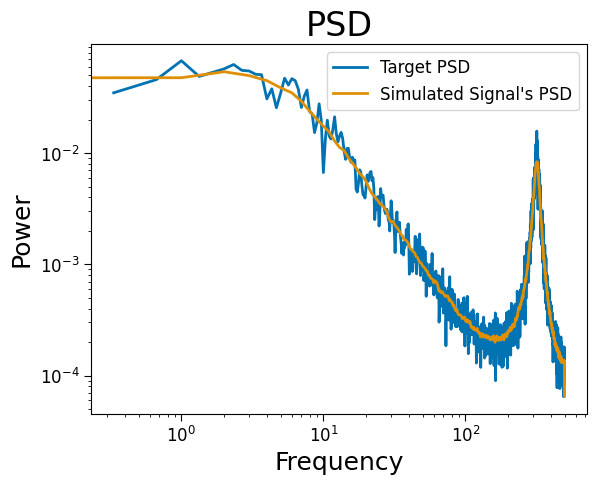

In [7]:
# Plot spectrum
plt.loglog(ar.freqs, ar.powers[-1], label="Target PSD")
plt.loglog(*compute_spectrum(simulated_signal, fs), label="Simulated Signal\'s PSD")
plt.legend(fontsize=12);
plt.title("PSD")
plt.ylabel("Power")
plt.xlabel("Frequency");

## Universal Approximation

The Brown noise fit in the first plot is relatively poor. A cheap solution is to scale the complexiy of the model up. The spectral form of an AR(p) is an inverse polynomial, leading to unversal approximation at the risk of overfitting.

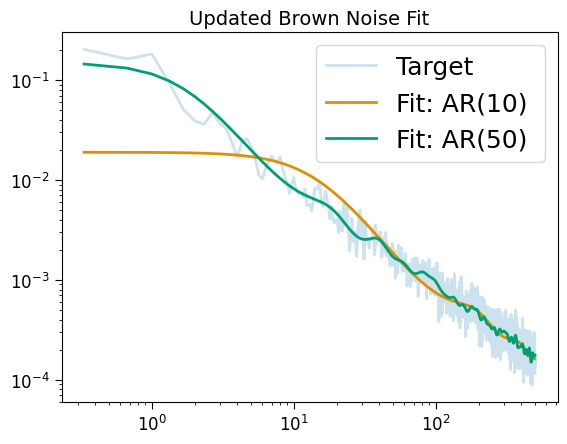

In [8]:
sig_brown = sigs[2]

ar_brown = ARPSD(
    50,
    fs,
    maxfev=1000,
    bounds=(-1000., 1000.),
    scaling='log'
)
ar_brown.fit(freqs[1:], powers[2, 1:])

plt.loglog(ar_brown.freqs, ar_brown.powers, label="Target", alpha=.2)
plt.loglog(ar_brown.freqs, ar.powers_fit[2], label="Fit: AR(10) ")
plt.loglog(ar_brown.freqs, ar_brown.powers_fit, label="Fit: AR(50)")
plt.legend()
plt.title("Updated Brown Noise Fit", size=14);

## Universal Approximation + Generative
We can combine universal approximation with the generative aspect of AR(p) models. Below we simulated a target PSD, and then generate a signal that matches.

The one caution is that complex spectra will require a high order AR model, which is more likely to converge to a non-stationary solution. Future work should aim to update the loss function to penalize non-stationary solutions based on the roots of the AR coefficients, $\varphi$.

### 1. AR(1) + Multiple Oscillations

In [9]:
# AR(1)
fs = 1000
freqs = np.logspace(0, np.log10(500), 1000)
powers = sim_ar_spectrum(freqs, fs, 0.95)

# Add Gaussian peaks
powers += 1e3 * np.exp(-(freqs - 10)**2 / 20) 
powers += 1e2 * np.exp(-(freqs - 60)**2 / 40) 

In [10]:
order = 40
np.random.seed(0)
guess = np.random.randn(order+1) * 1e-1
guess[-1] = 1.

arpsd = ARPSD(order, fs, bounds=(-1.1, 1.1), guess=guess, maxfev=1000)#, scaling='linear')
arpsd.fit(freqs, powers)

In [11]:
arpsd.is_stationary

True

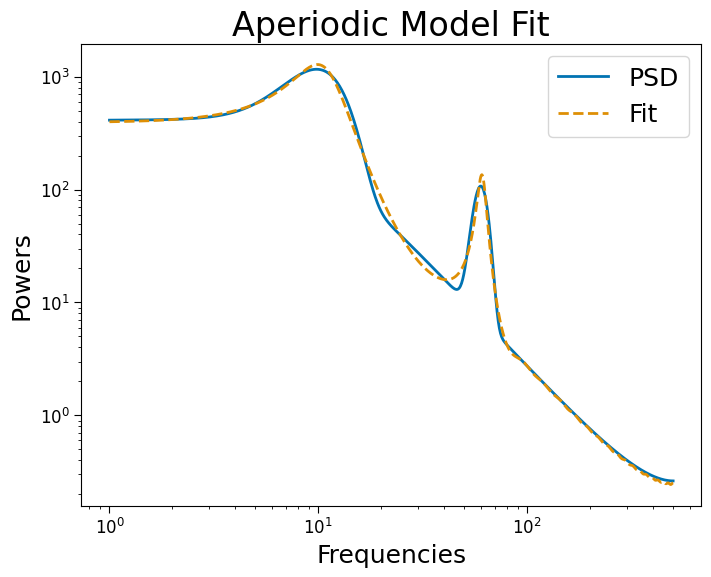

In [12]:
arpsd.plot()

Text(0, 0.5, 'Voltage, a.u.')

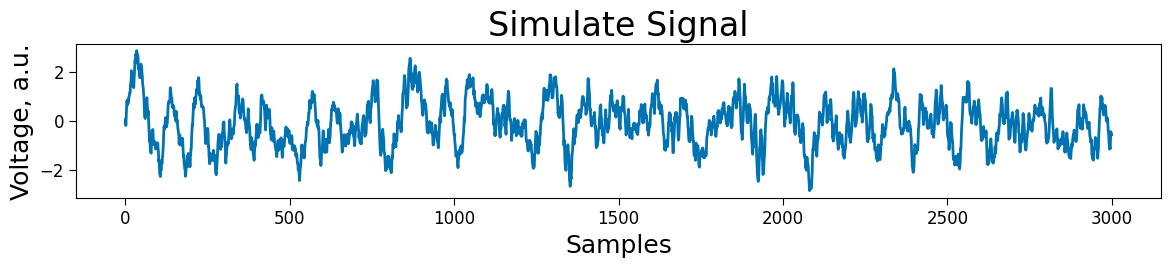

In [13]:
# Simulate
simulated_signal = arpsd.simulate(100, 1000)

# Plot
plt.figure(figsize=(14, 2))
plt.plot(simulated_signal[:3000])
plt.title("Simulate Signal")
plt.xlabel("Samples")
plt.ylabel("Voltage, a.u.")

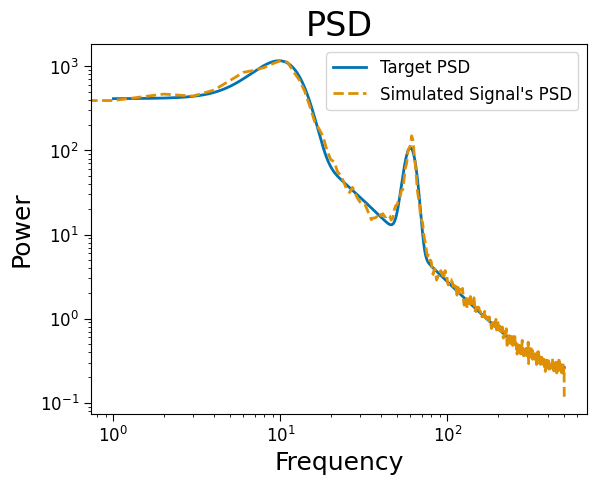

In [14]:
# Welch's PSD of the simulated signal
freqs_sim, powers_sim = compute_spectrum(simulated_signal, fs) 

# Plot spectra
plt.loglog(arpsd.freqs, arpsd.powers, label="Target PSD")
plt.loglog(freqs_sim, powers_sim/powers_sim.max()*arpsd.powers.max(),
           label="Simulated Signal\'s PSD", ls='--')
plt.legend(fontsize=12);
plt.title("PSD")
plt.ylabel("Power")
plt.xlabel("Frequency");

### 2. Single Oscillation

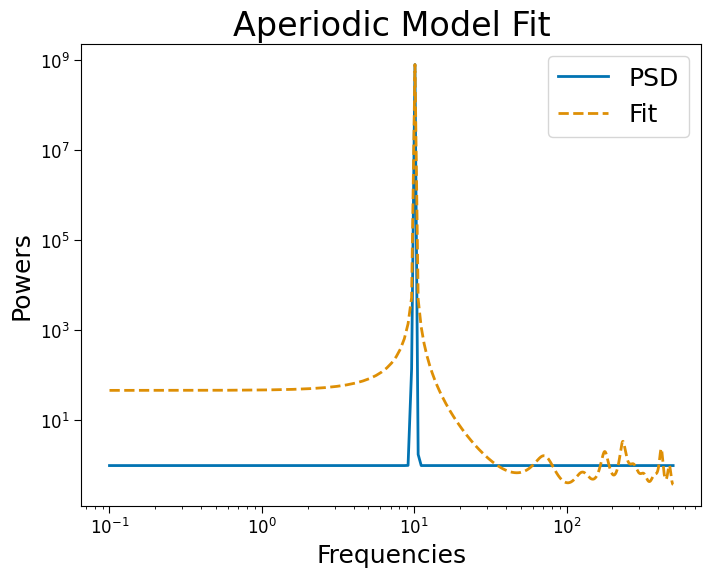

In [15]:
freqs = np.linspace(.1, 500, 1000)
powers = 10**(10 * np.exp(-(freqs - 10)**2 / .1))

order = 20
np.random.seed(0)
guess = np.random.randn(order+1) * 1e-1
guess[-1] = 1.

arpsd = ARPSD(order, fs, bounds=(-10, 10), guess=guess, maxfev=100, scaling='linear')
arpsd.fit(freqs, powers)
arpsd.plot()

In [16]:
arpsd.is_stationary

True

Text(0, 0.5, 'Voltage, a.u.')

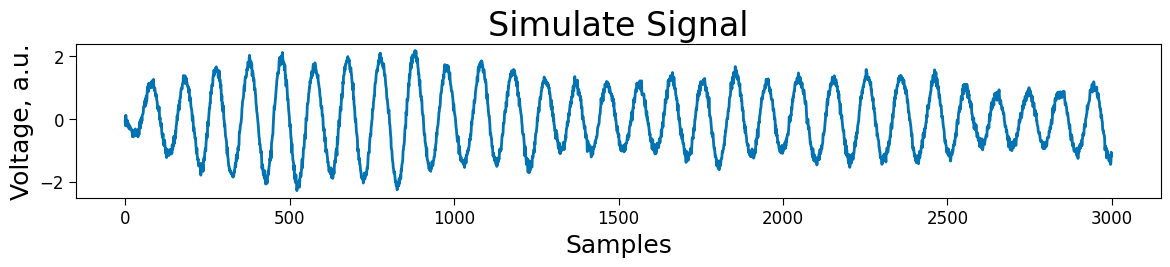

In [17]:
plt.figure(figsize=(14, 2))
plt.plot(arpsd.simulate(3, 1000))
plt.title("Simulate Signal")
plt.xlabel("Samples")
plt.ylabel("Voltage, a.u.")